In [121]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
from operator import itemgetter
import datetime as dt
import re

from pyspark import SparkConf
from pyspark import SparkContext
from pyspark.mllib.recommendation import ALS
from pyspark.mllib.recommendation import Rating

# conf = SparkConf().setMaster("local")
# sc = SparkContext(conf=conf)

### Download the simulated log data [here](https://s3.amazonaws.com/hudl-hadoop/pyspark-workshop/log-data.zip).

# The basics

### RDDs

The most basic abstraction is a Resilient Distributed Dataset (RDD). You can think of it as a distributed list, or array.

In [2]:
rdd = sc.parallelize([1, 2, 3, 4, 5])

### Transformations and actions

You can do two types of operations on RDD's: **transformations**, which return pointers to new RDD's and **actions** which bring results back to the driver, or master. The most basic transformation is `map` which maps a function to each element in an RDD.

In [3]:
rdd.map(lambda x: x + 1)

PythonRDD[1] at RDD at PythonRDD.scala:43

The above transformation increments each element by one. We can see the result by calling the `collect` action, which pulls the transformed RDD into memory as a list.

In [4]:
rdd.map(lambda x: x + 1).collect()

[2, 3, 4, 5, 6]

The `lambda` keyword creates an [anonymous function in Python](http://en.wikipedia.org/wiki/Anonymous_function#Python). The `map` transformation can also pass defined functions to every element.

In [5]:
def decrement(x):
    return x - 1

rdd.map(decrement).collect()

[0, 1, 2, 3, 4]

### Useful actions

Some very useful actions for getting a feel for an RDD are `first`, `take` and `takeSample`. Let's read in the Apache Spark [README.md](https://github.com/apache/spark/blob/master/README.md) as an RDD (each line is an element).

In [6]:
spark_readme_path = os.path.join(os.environ.get("SPARK_HOME"), "README.md")
spark_readme = sc.textFile(spark_readme_path)

In [7]:
spark_readme.first()

u'# Apache Spark'

In [8]:
spark_readme.take(10)

[u'# Apache Spark',
 u'',
 u'Spark is a fast and general cluster computing system for Big Data. It provides',
 u'high-level APIs in Scala, Java, and Python, and an optimized engine that',
 u'supports general computation graphs for data analysis. It also supports a',
 u'rich set of higher-level tools including Spark SQL for SQL and structured',
 u'data processing, MLlib for machine learning, GraphX for graph processing,',
 u'and Spark Streaming for stream processing.',
 u'',
 u'<http://spark.apache.org/>']

In [9]:
spark_readme.takeSample(withReplacement=False, num=10)

[u'',
 u'data processing, MLlib for machine learning, GraphX for graph processing,',
 u'distribution.',
 u'',
 u'',
 u'',
 u'# Apache Spark',
 u'',
 u'## Online Documentation',
 u'']

### Useful transformations: `filter`

The `filter` transformation maps a function to every element and only keeps the element if the function evaluates to `True`. The following returns all the lines from the `README` with URLs.

In [10]:
spark_readme.filter(lambda x: "http" in x).collect()

[u'<http://spark.apache.org/>',
 u'guide, on the [project web page](http://spark.apache.org/documentation.html)',
 u'and [project wiki](https://cwiki.apache.org/confluence/display/SPARK).',
 u'Spark is built using [Apache Maven](http://maven.apache.org/).',
 u'["Building Spark"](http://spark.apache.org/docs/latest/building-spark.html).',
 u'[run all automated tests](https://cwiki.apache.org/confluence/display/SPARK/Contributing+to+Spark#ContributingtoSpark-AutomatedTesting).',
 u'["Specifying the Hadoop Version"](http://spark.apache.org/docs/latest/building-with-maven.html#specifying-the-hadoop-version)',
 u'["Third Party Hadoop Distributions"](http://spark.apache.org/docs/latest/hadoop-third-party-distributions.html)',
 u'Please refer to the [Configuration guide](http://spark.apache.org/docs/latest/configuration.html)']

### Useful transformations: `flatMap`

A `flatMap` transformation takes a function that returns a list. The list is then exploded and each element is included in the transformed RDD. The following returns each character in the README as a separate element.

In [11]:
spark_readme.flatMap(lambda x: list(x)).take(14)

[u'#',
 u' ',
 u'A',
 u'p',
 u'a',
 u'c',
 u'h',
 u'e',
 u' ',
 u'S',
 u'p',
 u'a',
 u'r',
 u'k']

### The `reduce` action

`reduce` applies a function that takes two elements and returns one. Every element gets combined with another element until only one remains. A common `reduce` operation is sum. Below we `map` each line of the `README` to the number 1 and then `reduce` those ones with a sum function to get the total number of lines in the `README`.

In [12]:
spark_readme.map(lambda line: 1).reduce(lambda a, b: a + b)

98

We can get the largest (smallest) line by returning the larger (smaller) of two arguments.

In [13]:
spark_readme.reduce(lambda a, b: a if len(a) > len(b) else b)

u'[run all automated tests](https://cwiki.apache.org/confluence/display/SPARK/Contributing+to+Spark#ContributingtoSpark-AutomatedTesting).'

# Munging 101

In [14]:
logs = sc.textFile("./log-data/")

### How many logs are there in the `log-data/` folder?

In [15]:
logs.count()

134403

### What does one of the logs look like?

In [16]:
logs.first()

u'2015-04-30 03:02:59,000 p-web-a-zfkgty [INFO ] [Audit] App=Hudl,Func=View,Op=PremiumHighlight,Ip=477.735.511.568,AuthUser=1371068817,Role=Participant,Attributes=[HighlightReel=62029817,Privacy=Public,Player=Flash,IsRendered=Unknown,IsYouTube=False,IsMobile=False,PageSource=EmbeddablePlayer]'

### Get the date from all the logs (you can leave them as strings)

In [20]:
times = logs.map(lambda x: " ".join(x.split()[:2]))
times.take(10)

[u'2015-04-30 03:02:59,000',
 u'2015-04-30 03:03:43,000',
 u'2015-04-30 03:04:34,000',
 u'2015-04-30 03:05:33,000',
 u'2015-04-30 03:06:03,000',
 u'2015-04-30 03:06:39,000',
 u'2015-04-30 03:07:15,000',
 u'2015-04-30 03:08:14,000',
 u'2015-04-30 03:09:12,000',
 u'2015-04-30 03:09:40,000']

### How many unique days are represented?

In [21]:
times.map(lambda x: x.split()[0]).distinct().collect()

[u'2015-05-03',
 u'2015-05-02',
 u'2015-05-01',
 u'2015-04-30',
 u'2015-05-06',
 u'2015-05-05',
 u'2015-05-04']

# Descriptives

### Helpful datetime arithmetic tricks

In [22]:
dt.datetime(2014, 1, 1) < dt.datetime(2015, 1, 1)

True

In [23]:
dt.datetime(2014, 1, 1) + dt.timedelta(365)

datetime.datetime(2015, 1, 1, 0, 0)

In [24]:
day_diff = dt.datetime(2014, 1, 2) - dt.datetime(2014, 1, 1)
day_diff.total_seconds()

86400.0

In [25]:
def datetime_from_log(log):
    """Accepts a view log as input and returns a datetime object"""
    pattern = re.compile("\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}")
    date_str = pattern.findall(log)[0]
    
    return dt.datetime.strptime(date_str, "%Y-%m-%d %H:%M:%S")

### When is the first view? (Hint: try to use the `reduce` action)

In [26]:
logs.map(datetime_from_log).reduce(lambda a, b: a if a < b else b)

datetime.datetime(2015, 4, 30, 0, 0)

### When is the last view? (Hint: Spark also has a built-in action for that)

In [27]:
logs.map(datetime_from_log).max()

datetime.datetime(2015, 5, 6, 23, 59, 55)

### How many PremiumHighlight Views per hour are there?

In [28]:
num_views = times.map(lambda x: x.split(":")[0]) \
    .map(lambda x: (x, 1)) \
    .reduceByKey(lambda a, b: a + b) \
    .sortByKey()
    
num_views_list = num_views.collect()

In [29]:
num_views_list[:10]

[(u'2015-04-30 00', 1613),
 (u'2015-04-30 01', 1539),
 (u'2015-04-30 02', 1773),
 (u'2015-04-30 03', 1676),
 (u'2015-04-30 04', 1392),
 (u'2015-04-30 05', 990),
 (u'2015-04-30 06', 887),
 (u'2015-04-30 07', 675),
 (u'2015-04-30 08', 492),
 (u'2015-04-30 09', 419)]

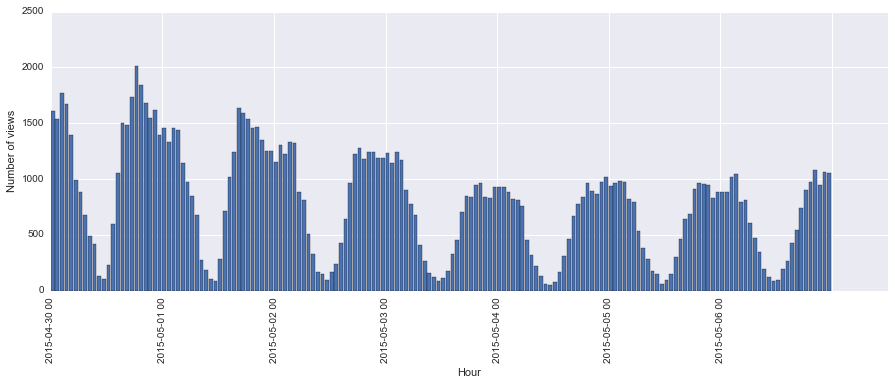

In [30]:
plt.figure(figsize=(15, 5))
plt.bar(range(len(num_views_list)), map(itemgetter(1), num_views_list))

plt.xticks(range(0, 180, 24), map(itemgetter(0), num_views_list)[::24], rotation=90)

plt.ylabel("Number of views")
plt.xlabel("Hour")
plt.show()

In [31]:
views_per_hour_of_day = num_views.map(lambda x: (x[0].split()[1], x[1])) \
    .groupByKey() \
    .sortByKey() \
    .map(lambda x: (int(x[0]), x[1].data)) \
    .collect()

In [32]:
views_per_hour_of_day

[(0, [1613, 1456, 1154, 1231, 926, 939, 884]),
 (1, [1539, 1336, 1305, 1142, 928, 965, 883]),
 (2, [1773, 1454, 1223, 1246, 882, 982, 1016]),
 (3, [1676, 1441, 1330, 1170, 820, 977, 1049]),
 (4, [1392, 1141, 1320, 900, 808, 820, 790]),
 (5, [990, 974, 887, 780, 761, 798, 810]),
 (6, [887, 844, 812, 678, 454, 538, 610]),
 (7, [675, 674, 511, 411, 316, 386, 473]),
 (8, [492, 279, 325, 268, 223, 285, 342]),
 (9, [419, 189, 163, 161, 134, 176, 195]),
 (10, [129, 105, 147, 125, 61, 145, 125]),
 (11, [101, 88, 95, 87, 54, 64, 83]),
 (12, [229, 281, 165, 115, 73, 91, 92]),
 (13, [594, 712, 239, 174, 171, 149, 191]),
 (14, [1054, 1020, 429, 324, 312, 297, 263]),
 (15, [1499, 1238, 639, 453, 467, 466, 429]),
 (16, [1485, 1641, 965, 705, 671, 645, 542]),
 (17, [1732, 1595, 1228, 852, 773, 685, 738]),
 (18, [2009, 1540, 1278, 839, 841, 910, 899]),
 (19, [1845, 1455, 1176, 947, 962, 966, 974]),
 (20, [1681, 1465, 1242, 967, 896, 954, 1081]),
 (21, [1546, 1347, 1246, 839, 868, 950, 947]),
 (22, [16

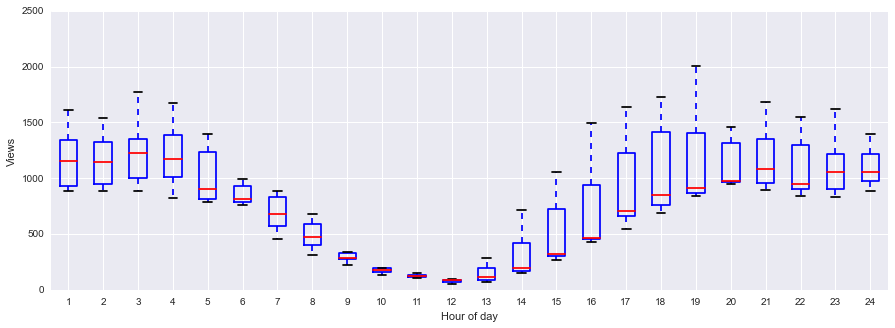

In [33]:
plt.figure(figsize=(15, 5))
plt.boxplot(map(itemgetter(1), views_per_hour_of_day))
plt.ylabel("Views")
plt.xlabel("Hour of day")
plt.show()

### What's the average wait time (seconds) between views?

In [39]:
## Hint: you can use the `zipWithIndex` method
times.zipWithIndex().take(10)

[(u'2015-04-30 03:02:59,000', 0),
 (u'2015-04-30 03:03:43,000', 1),
 (u'2015-04-30 03:04:34,000', 2),
 (u'2015-04-30 03:05:33,000', 3),
 (u'2015-04-30 03:06:03,000', 4),
 (u'2015-04-30 03:06:39,000', 5),
 (u'2015-04-30 03:07:15,000', 6),
 (u'2015-04-30 03:08:14,000', 7),
 (u'2015-04-30 03:09:12,000', 8),
 (u'2015-04-30 03:09:40,000', 9)]

In [53]:
times_with_index = times.map(datetime_from_log) \
    .sortBy(lambda x: x) \
    .zipWithIndex() \
    .map(lambda x: x[::-1])
    
wait_times = times_with_index.map(lambda x: (x[0] + 1, x[1])) \
    .join(times_with_index) \
    .map(lambda x: x[1]) \
    .map(lambda x: (x[1] - x[0]).total_seconds()) \
    .collect()

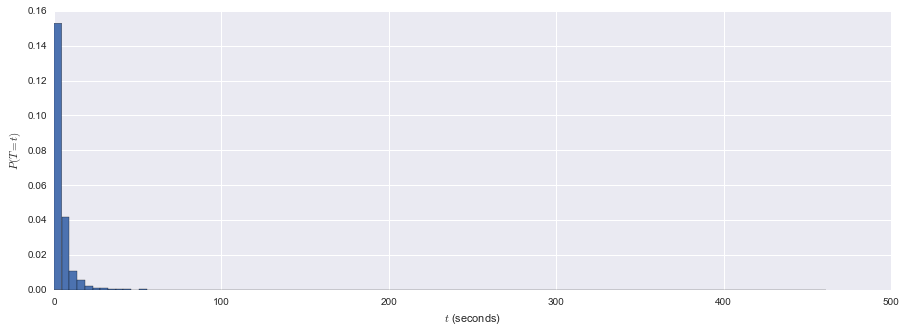

In [68]:
plt.figure(figsize=(15, 5))
plt.hist(wait_times, bins=100, normed=True)
plt.xlabel("$t$ (seconds)")
plt.ylabel("$P(T=t)$")
plt.show()

In [67]:
sum([t > 2 for t in wait_times]) / float(len(wait_times))

0.49293165280278567

### Pull out AuthUser and HighlightReel for each log

In [103]:
def user_highlight_pair(log):
    user_pattern = re.compile("AuthUser=\d+")
    reel_pattern = re.compile("HighlightReel=\d+")
    authuser = user_pattern.findall(log)[0]
    highlightreel = reel_pattern.findall(log)[0]
    
    return (authuser, highlightreel)

In [105]:
views = logs.map(user_highlight_pair)

### If all users/highlights fit in memory

In [106]:
all_users = views.map(lambda x: x[0]).distinct().collect()
all_highlights = views.map(lambda x: x[1]).distinct().collect()

In [107]:
user_dict = {}
for i, u in enumerate(all_users):
    user_dict[u] = i
    
highlight_dict = {}
for i, h in enumerate(all_highlights):
    highlight_dict[h] = i

In [108]:
user_dict_b = sc.broadcast(user_dict)
highlight_dict_b = sc.broadcast(highlight_dict)

In [109]:
indexed_views = views.map(lambda x: (user_dict_b.value[x[0]], highlight_dict_b.value[x[1]]))

### If users/highlights don't fit in memory

In [110]:
all_users = views.map(lambda x: x[0]).distinct().zipWithIndex()
all_highlights = views.map(lambda x: x[1]).distinct().zipWithIndex()

In [111]:
indexed_views = views.leftOuterJoin(all_users) \
    .map(lambda x: x[1]) \
    .leftOuterJoin(all_highlights) \
    .map(lambda x: x[1])

In [113]:
print views.map(lambda x: x[0]).distinct().count() - 1
print indexed_views.map(lambda x: x[0]).max()

39282
39282


In [114]:
print views.map(lambda x: x[1]).distinct().count() - 1
print indexed_views.map(lambda x: x[1]).max()

62151
62151


In [119]:
rank = 10
iterations = 20

In [122]:
ratings = indexed_views.groupBy(lambda x: x) \
    .map(lambda x: Rating(x[0][0], x[0][1], len(x[1].data)))

In [123]:
# Build the recommendation model using Alternating Least Squares based on implicit ratings
model = ALS.trainImplicit(ratings, rank, iterations)

In [126]:
model.predict(1, 2)

9.919003503210321e-29